## Compute and Pool Reconstructed Cell Morphology Statistics

Run this notebook from repo root

It takes cell morphology SWC files in repo root/morphology-data/ folder and computes a set of morphology statistics. Each folder is an archive from NeuroMorpho

The stats are then pooled across archives and pooled values stored in the sqlite database

In [1]:
import sys
import os
my_path = os.path.dirname(os.getcwd())  # '/home/ellismith/OlfactoryBulb'
sys.path.append(my_path)
from olfactorybulb.database import *
import os,sys

import matplotlib.pyplot as plt
from neuronunit.tests.morphology import *
from neuronunit.models.morphology import SwcCellModel
from sciunit.suites import TestSuite
import pandas as pd
from pandas import DataFrame
from pathlib import Path
import pylmeasure
from sklearn.decomposition import PCA

Import of eden.EdenBackend failed due to:
No module named 'eden_simulator'


In [2]:
main_path = Path('/home/ellismith/OlfactoryBulb')
#files_dir = main_path / 'prev_ob_models/Birgiolas2020/morphology'
files_dir = main_path / 'prev_ob_models/Birgiolas2020/SWCs/GC'
pylmeasure.ROOT_PATH = files_dir

In [3]:
measure_list = ['Soma_Surface',
 'N_stems',
 'N_bifs',
 'N_branch',
 'N_tips',
 'Width',
 'Height',
 'Depth',
 'Type',
 'Diameter',
 'Diameter_pow',
 'Length',
 'Surface',
 'SectionArea',
 'Volume',
 'EucDistance',
 'PathDistance',
 'Branch_Order',
 'Terminal_degree',
 'TerminalSegment',
 'Taper_1',
 'Taper_2',
 'Branch_pathlength',
 'Contraction',
 'Fragmentation',
 'Daughter_Ratio',
 'Parent_Daughter_Ratio',
 'Partition_asymmetry',
 'Rall_Power',
 'Pk',
 'Pk_classic',
 'Pk_2',
 'Bif_ampl_local',
 'Bif_ampl_remote',
 'Bif_tilt_local',
 'Bif_tilt_remote',
 'Bif_torque_local',
 'Bif_torque_remote',
 'Last_parent_diam',
 'Diam_threshold',
 'HillmanThreshold',
 'Helix',
 'Fractal_Dim']

In [4]:
len(measure_list)

43

In [5]:
def get_LM_df(measure_list, swcFiles, stats = ['Average', 'Minimum', 'Maximum']):
    
    LMOutput = pylmeasure.getMeasure(measure_list, swcFiles)


    LM_dict = {measure : LMOutput[measure_list.index(measure)]["WholeCellMeasuresDict"] for measure in measure_list} 

    LM_df = pd.DataFrame(LM_dict)
    LM_df.insert(loc=0, column='file', value=swcFiles)

    all_dfs = []
    for measure in measure_list:
        df_measure = LM_df[measure].apply(pd.Series)  # splits the dictionary into separate columns
        df_measure = df_measure[stats]  # selecting just the feature avg, min, & max
        df_measure.columns = pd.MultiIndex.from_product([[measure], stats],
                                                        names=['Measure', 'Stat'])
        all_dfs.append(df_measure)

    df_measure = pd.concat(all_dfs, axis=1)
    df_measure.index = pd.Index([x.split('/')[-1] for x in swcFiles], name='File')
    return df_measure

In [6]:
# Define a list of one or more SWC files to analyze
files = list(files_dir.glob('*.swc'))

# Posix path object path --> list of swc paths that is iterable
files_list = []
for i in range(len(files)):
    files_list.append(str(files[i]))

In [7]:
# gets a dataframe with the min, max, and average measures for the top2 files
df = get_LM_df(measure_list, files_list)

In [8]:
files_list[1]

'/home/ellismith/OlfactoryBulb/prev_ob_models/Birgiolas2020/SWCs/GC/OB_granule_cell11.CNG.swc'

In [9]:
z = df.xs('Average', axis=1, level=1)

In [10]:
z

Measure,Soma_Surface,N_stems,N_bifs,N_branch,N_tips,Width,Height,Depth,Type,Diameter,...,Bif_ampl_remote,Bif_tilt_local,Bif_tilt_remote,Bif_torque_local,Bif_torque_remote,Last_parent_diam,Diam_threshold,HillmanThreshold,Helix,Fractal_Dim
File,,,,,,,,,,,,,,,,,,,,,
OB_granule_cell7.CNG.swc,11.99430,1.0,1.0,1.0,1.0,103.66,246.30,94.10,3.98225,1.01044,...,48.8420,118.0750,139.704,137.2060,92.0200,1.00000,1.50400,1.50400,-0.000339,1.02395
OB_granule_cell11.CNG.swc,31.08990,1.0,1.0,1.0,1.0,68.54,268.58,105.86,3.98056,1.05815,...,54.7456,109.4520,139.018,106.3150,71.3583,1.16924,1.98567,2.05352,0.001485,1.04022
OB_granule_cell2.CNG.swc,8.04734,1.0,1.0,1.0,1.0,87.11,273.33,89.23,3.98308,1.00713,...,42.2132,115.4510,148.069,102.9090,67.0704,1.00000,1.31600,1.31600,0.002770,1.02490
OB_granule_cell6.CNG.swc,36.02220,1.0,1.0,1.0,1.0,91.64,334.81,166.62,3.98558,1.01822,...,53.7609,115.9680,141.393,63.5970,68.4021,1.00000,1.94750,1.94750,0.001244,1.02558
OB_granule_cell4.CNG.swc,22.31430,1.0,1.0,1.0,1.0,97.71,130.75,168.44,3.97982,1.01863,...,59.5112,83.6561,124.738,41.5966,64.5433,1.00000,1.79143,1.79143,-0.001156,1.01663


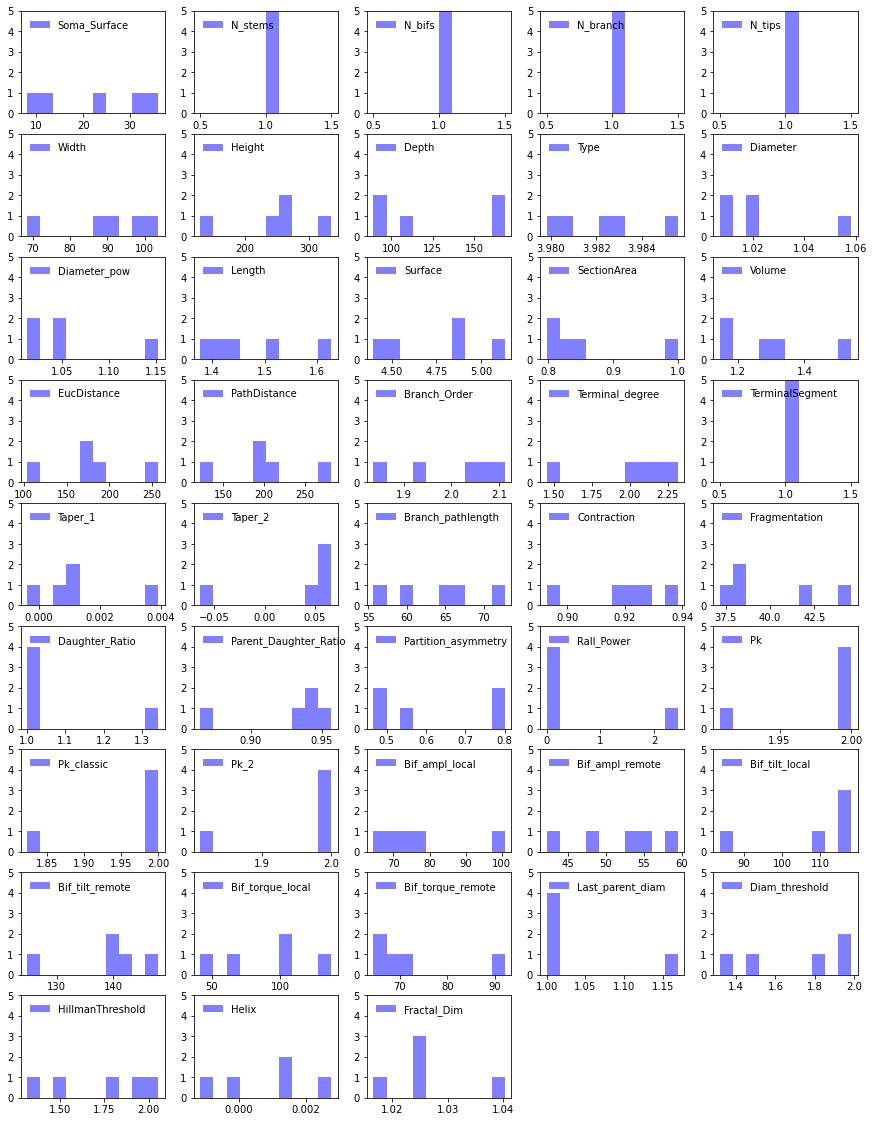

In [11]:
# Generically define how many plots along and across
ncols = 5
nrows = 9
#nrows = int(np.ceil(len(df.columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))

# Lazy counter so we can remove unwated axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(z.columns):

            ax.hist(z[z.columns[counter]], bins=10, color='blue', alpha=0.5, label='{}'.format(z.columns[counter]))
            #ax.set_xlabel('um or unitless')
            #ax.set_ylabel('LM function')
            ax.set_ylim([0, 5])
            leg = ax.legend(loc='upper left')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

#plt.show()
plt.savefig('GC_LM_summary.png')

In [12]:
def get_morphology(file_name: str):

    """ Return morphology df

  Args:
    file_name (str): Neuromorpho swc file name

  Returns:
    df (DataFrame): dataframe with length and angle (theta) values taken from the principal components of the x, y coordinate values
    """

    with open(file_name, "rb") as f:  # rb = read only, binary
        data = f.read().decode("utf-8")   # utf is a unicode standard

    data = data.split("\r\n")  # rn is the "token"

    # making each item a list, split on the space
    # also removing all the comments at the beginning, the len(line)>0 is to account for blank lines
    # the .strip is to get rid of blank spaces
    data_list = [line.strip().split(" ") for line in data if len(line)>0 and line[0]!='#']

    df = pd.DataFrame(data_list, columns=["sample", "structure", "x", "y", "z",
                                          "diameter", "parent"])
    df = df.set_index("sample").iloc[:-1]  # omit last line cuz it's blank
    df = df.astype({"structure": int, "x": float, "y": float, "z": float,
                    "diameter": float, "parent": int})
    df.index = df.index.astype(int)   # 1, 2, 3 not "1" etc


    # now we know the very original parent for each sample (each sample is represented as a circle)
    def funct(s):  # s is the series
        parent = max(1, s["parent"])  # this function gives us values unless it's less than 1
        return df.loc[parent]

    # now we have vectors between the samples, the x, y, x vals
    delta = df - df.apply(funct, axis=1)

    # replacing the -1 parent value for the first sample with 0
    df.loc[df['parent'] < 0, 'parent'] = 0

    return df, file_name

In [13]:
swc_dfs = []
for file in files_list:
    df, file_name = get_morphology(file)
    swc_dfs.append(df)

In [30]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange


def draw_neuron(swc_df, a='y', b='z', marker_color='green', ax=None):
    if ax is None:  
        plt.figure(figsize=(8, 8))
        ax=plt.gca()
    
    x = []; y = []
    for sample in swc_df.index:
        parent = swc_df.loc[sample, 'parent']
        if sample>1 and parent == (sample-1): # If this is contiguous with the previous sample
            x.append(swc_df.loc[sample, a]) # Just append to the list of points to draw
            y.append(swc_df.loc[sample, b]) # Ditto
        else: # If it is not contiguous (i.e. new branch)
            ax.plot(x, y, 'o-', markersize=0.5, color=marker_color) # Draw the x,y so far accumulated
            x = [swc_df.loc[sample, a]] # And start a new list of x's for this new branch
            y = [swc_df.loc[sample, b]] # Ditto for y
    plt.savefig('GC_yz.png')

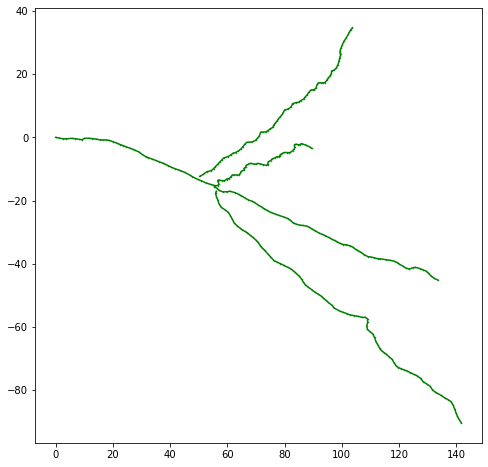

In [35]:
draw_neuron(swc_dfs[4])

## justas':

In [16]:
def get_swc_models_from_files(dir):
    files = os.listdir(dir)
    files = [os.path.join(dir,file) for file in files if file.endswith('.swc')]
    models = [SwcCellModel(file) for file in files]
    return models

In [17]:
from quantities import um
blank_obs = {'mean': 0, 'n': 1, 'std': 1}
blank_obs_um = {'mean': 0*um, 'n': 1, 'std': 1*um}
blank_obs_um2 = {'mean': 0*um**2, 'n': 1, 'std': 1*um**2}
blank_obs_um3 = {'mean': 0*um**3, 'n': 1, 'std': 1*um**3}

soma_tests = [    
    SomaSurfaceAreaTest(blank_obs_um2),
    NumberofStemsTest(blank_obs),
]

basal_tests = [    
    BasalDendriteNumberofBifurcationsTest(blank_obs),
    BasalDendriteNumberofBranchesTest(blank_obs),
    BasalDendriteOverallWidthTest(blank_obs_um),
    BasalDendriteOverallHeightTest(blank_obs_um),
    BasalDendriteOverallDepthTest(blank_obs_um),
    BasalDendriteAverageDiameterTest(blank_obs_um),
    BasalDendriteTotalLengthTest(blank_obs_um),
    BasalDendriteTotalSurfaceTest(blank_obs_um2),
    BasalDendriteTotalVolumeTest(blank_obs_um3),
    BasalDendriteMaxEuclideanDistanceTest(blank_obs_um),
    BasalDendriteMaxPathDistanceTest(blank_obs_um),
    BasalDendriteMaxBranchOrderTest(blank_obs),
    BasalDendriteAverageContractionTest(blank_obs),
    BasalDendritePartitionAsymmetryTest(blank_obs),
    BasalDendriteAverageRallsRatioTest(blank_obs),
    BasalDendriteAverageBifurcationAngleLocalTest(blank_obs),
    BasalDendriteAverageBifurcationAngleRemoteTest(blank_obs),
    BasalDendriteFractalDimensionTest(blank_obs),
]

apical_tests = [    
    ApicalDendriteNumberofBifurcationsTest(blank_obs),
    ApicalDendriteNumberofBranchesTest(blank_obs),
    ApicalDendriteOverallWidthTest(blank_obs_um),
    ApicalDendriteOverallHeightTest(blank_obs_um),
    ApicalDendriteOverallDepthTest(blank_obs_um),
    ApicalDendriteAverageDiameterTest(blank_obs_um),
    ApicalDendriteTotalLengthTest(blank_obs_um),
    ApicalDendriteTotalSurfaceTest(blank_obs_um2),
    ApicalDendriteTotalVolumeTest(blank_obs_um3),
    ApicalDendriteMaxEuclideanDistanceTest(blank_obs_um),
    ApicalDendriteMaxPathDistanceTest(blank_obs_um),
    ApicalDendriteMaxBranchOrderTest(blank_obs),
    ApicalDendriteAverageContractionTest(blank_obs),
    ApicalDendritePartitionAsymmetryTest(blank_obs),
    ApicalDendriteAverageRallsRatioTest(blank_obs),
    ApicalDendriteAverageBifurcationAngleLocalTest(blank_obs),
    ApicalDendriteAverageBifurcationAngleRemoteTest(blank_obs),
    ApicalDendriteFractalDimensionTest(blank_obs),
]

full_slice_only_tests = [
    'ApicalDendriteNumberofBifurcationsTest', 
    'ApicalDendriteNumberofBranchesTest',
    'ApicalDendriteOverallDepthTest',
    'ApicalDendriteTotalLengthTest',
    'ApicalDendriteTotalSurfaceTest',
    'ApicalDendriteTotalVolumeTest',
    
    'BasalDendriteNumberofBifurcationsTest', 
    'BasalDendriteNumberofBranchesTest',
    'BasalDendriteOverallDepthTest',
    'BasalDendriteTotalLengthTest',
    'BasalDendriteTotalSurfaceTest',
    'BasalDendriteTotalVolumeTest',
]

full_diameter_only_tests = [
    'ApicalDendriteAverageDiameterTest',
    'ApicalDendriteTotalSurfaceTest',
    'ApicalDendriteTotalVolumeTest',
    'ApicalDendriteAverageContractionTest',
    'ApicalDendriteAverageRallsRatioTest',
    
    'BasalDendriteAverageDiameterTest',
    'BasalDendriteTotalSurfaceTest',
    'BasalDendriteTotalVolumeTest',
    'BasalDendriteAverageContractionTest',
    'BasalDendriteAverageRallsRatioTest',
]

soma_suite = TestSuite(soma_tests)
basal_suite = TestSuite(basal_tests)
apical_suite = TestSuite(apical_tests)

In [18]:
def get_property_id(CellShort, test):
    test_to_property_map = {
        "SomaSurfaceAreaTest": CellShort + "_Soma_Surface_Area",
        "NumberofStemsTest": CellShort + "_Number_of_Stems",
        "BasalDendriteNumberofBifurcationsTest": CellShort + "_Basal_Dendrite_Number_of_Bifurcations",
        "BasalDendriteNumberofBranchesTest": CellShort + "_Basal_Dendrite_Number_of_Branches",
        "BasalDendriteOverallWidthTest": CellShort + "_Basal_Dendrite_Overall_Width",
        "BasalDendriteOverallHeightTest": CellShort + "_Basal_Dendrite_Overall_Height",
        "BasalDendriteOverallDepthTest": CellShort + "_Basal_Dendrite_Overall_Depth",
        "BasalDendriteAverageDiameterTest": CellShort + "_Basal_Dendrite_Average_Diameter",
        "BasalDendriteTotalLengthTest": CellShort + "_Basal_Dendrite_Total_Length",
        "BasalDendriteTotalSurfaceTest": CellShort + "_Basal_Dendrite_Total_Surface",
        "BasalDendriteTotalVolumeTest": CellShort + "_Basal_Dendrite_Total_Volume",
        "BasalDendriteMaxEuclideanDistanceTest": CellShort + "_Basal_Dendrite_Max_Euclidean_Distance",
        "BasalDendriteMaxPathDistanceTest": CellShort + "_Basal_Dendrite_Max_Path_Distance",
        "BasalDendriteMaxBranchOrderTest": CellShort + "_Basal_Dendrite_Max_Branch_Order",
        "BasalDendriteAverageContractionTest": CellShort + "_Basal_Dendrite_Average_Contraction",
        "BasalDendritePartitionAsymmetryTest": CellShort + "_Basal_Dendrite_Partition_Asymmetry",
        "BasalDendriteAverageRallsRatioTest": CellShort + "_Basal_Dendrite_Average_Ralls_Ratio",
        "BasalDendriteAverageBifurcationAngleLocalTest": CellShort + "_Basal_Dendrite_Average_Bifurcation_Angle_Local",
        "BasalDendriteAverageBifurcationAngleRemoteTest": CellShort + "_Basal_Dendrite_Average_Bifurcation_Angle_Remote",
        "BasalDendriteFractalDimensionTest": CellShort + "_Basal_Dendrite_Fractal_Dimension",
        "ApicalDendriteNumberofBifurcationsTest": CellShort + "_Apical_Dendrite_Number_of_Bifurcations",
        "ApicalDendriteNumberofBranchesTest": CellShort + "_Apical_Dendrite_Number_of_Branches",
        "ApicalDendriteOverallWidthTest": CellShort + "_Apical_Dendrite_Overall_Width",
        "ApicalDendriteOverallHeightTest": CellShort + "_Apical_Dendrite_Overall_Height",
        "ApicalDendriteOverallDepthTest": CellShort + "_Apical_Dendrite_Overall_Depth",
        "ApicalDendriteAverageDiameterTest": CellShort + "_Apical_Dendrite_Average_Diameter",
        "ApicalDendriteTotalLengthTest": CellShort + "_Apical_Dendrite_Total_Length",
        "ApicalDendriteTotalSurfaceTest": CellShort + "_Apical_Dendrite_Total_Surface",
        "ApicalDendriteTotalVolumeTest": CellShort + "_Apical_Dendrite_Total_Volume",
        "ApicalDendriteMaxEuclideanDistanceTest": CellShort + "_Apical_Dendrite_Max_Euclidean_Distance",
        "ApicalDendriteMaxPathDistanceTest": CellShort + "_Apical_Dendrite_Max_Path_Distance",
        "ApicalDendriteMaxBranchOrderTest": CellShort + "_Apical_Dendrite_Max_Branch_Order",
        "ApicalDendriteAverageContractionTest": CellShort + "_Apical_Dendrite_Average_Contraction",
        "ApicalDendritePartitionAsymmetryTest": CellShort + "_Apical_Dendrite_Partition_Asymmetry",
        "ApicalDendriteAverageRallsRatioTest": CellShort + "_Apical_Dendrite_Average_Ralls_Ratio",
        "ApicalDendriteAverageBifurcationAngleLocalTest": CellShort + "_Apical_Dendrite_Average_Bifurcation_Angle_Local",
        "ApicalDendriteAverageBifurcationAngleRemoteTest": CellShort + "_Apical_Dendrite_Average_Bifurcation_Angle_Remote",
        "ApicalDendriteFractalDimensionTest": CellShort + "_Apical_Dendrite_Fractal_Dimension",
    }
    
    return test_to_property_map[test]

In [19]:
def compute_morphology_stats(dir, CellShort, test_set, exclude, source_id):
    models = get_swc_models_from_files(dir)
    
    test_results = {}
    for m, model in enumerate(models):
        for test in test_set:
            test_name = test.__class__.__name__
            
            if test_name in exclude:
                continue
            
            prediction = test.generate_prediction(model)["mean"]

            if test_name not in test_results:
                test_results[test_name] = []

            test_results[test_name].append(prediction)
        
        print(m+1,"out of", len(models))

    import numpy as np
    import re

    for key in test_results:
        test_results[key] = {
            'mean': np.mean(test_results[key]),
            'std': np.std(test_results[key]),
            'n': len(test_results[key]),
            'property_id': get_property_id(CellShort, key),
            'source_id': source_id,
        }

    no_0_stdev = {}
    for key in test_results:
        if test_results[key]['std'] > 0:
            no_0_stdev[key] = test_results[key]
    test_results = no_0_stdev
    
    return test_results

## Caile GC archive

Computed soma and thin slice metrics for apical dends

In [20]:
# Apical
stats = compute_morphology_stats(dir='%s/morphology-data/GCs/Caile-granule/done/'%my_path,
                             CellShort="GC", 
                             test_set=apical_tests, 
                             exclude=full_slice_only_tests,
                             source_id=28)\
        .values()



1 out of 29
2 out of 29
3 out of 29
4 out of 29
5 out of 29
6 out of 29
7 out of 29
8 out of 29
9 out of 29
10 out of 29
11 out of 29
12 out of 29
13 out of 29
14 out of 29
15 out of 29
16 out of 29
17 out of 29
18 out of 29
19 out of 29
20 out of 29
21 out of 29
22 out of 29
23 out of 29
24 out of 29
25 out of 29
26 out of 29
27 out of 29
28 out of 29
29 out of 29


In [21]:
DataFrame(stats).sort("property_id")

AttributeError: 'DataFrame' object has no attribute 'sort'

In [ ]:
Measurement.insert(stats).execute()

NameError: name 'stats' is not defined

In [ ]:
# Basal
stats = compute_morphology_stats(dir='morphology-data/GCs/Caile-granule/done/',
                             CellShort="GC", 
                             test_set=basal_tests, 
                             exclude=full_slice_only_tests,
                             source_id=28)\
        .values()

DataFrame(stats).sort("property_id")

FileNotFoundError: [Errno 2] No such file or directory: 'morphology-data/GCs/Caile-granule/done/'

In [ ]:
Measurement.insert(stats).execute()

298

In [ ]:
# Soma
stats = compute_morphology_stats(dir='morphology-data/GCs/Caile-granule/done/',
                             CellShort="GC", 
                             test_set=soma_tests, 
                             exclude=full_slice_only_tests,
                             source_id=28)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 29)
(2, 'out of', 29)
(3, 'out of', 29)
(4, 'out of', 29)
(5, 'out of', 29)
(6, 'out of', 29)
(7, 'out of', 29)
(8, 'out of', 29)
(9, 'out of', 29)
(10, 'out of', 29)
(11, 'out of', 29)
(12, 'out of', 29)
(13, 'out of', 29)
(14, 'out of', 29)
(15, 'out of', 29)
(16, 'out of', 29)
(17, 'out of', 29)
(18, 'out of', 29)
(19, 'out of', 29)
(20, 'out of', 29)
(21, 'out of', 29)
(22, 'out of', 29)
(23, 'out of', 29)
(24, 'out of', 29)
(25, 'out of', 29)
(26, 'out of', 29)
(27, 'out of', 29)
(28, 'out of', 29)
(29, 'out of', 29)


,mean,n,property_id,source_id,std
1,3.000000,29,GC_Number_of_Stems,28,1.531283
0,210.936755,29,GC_Soma_Surface_Area,28,77.956143


In [ ]:
Measurement.insert(stats).execute()

300

## Denizet GC archive - Denizet 2017 paper

Thin, no soma

In [ ]:
dir = 'morphology-data/GCs/Denizet-granule/Denizet2017'
cell = "GC"
exclude = full_slice_only_tests
source_id=29

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 278)
(2, 'out of', 278)
(3, 'out of', 278)
(4, 'out of', 278)
(5, 'out of', 278)
(6, 'out of', 278)
(7, 'out of', 278)
(8, 'out of', 278)
(9, 'out of', 278)
(10, 'out of', 278)
(11, 'out of', 278)
(12, 'out of', 278)
(13, 'out of', 278)
(14, 'out of', 278)
(15, 'out of', 278)
(16, 'out of', 278)
(17, 'out of', 278)
(18, 'out of', 278)
(19, 'out of', 278)
(20, 'out of', 278)
(21, 'out of', 278)
(22, 'out of', 278)
(23, 'out of', 278)
(24, 'out of', 278)
(25, 'out of', 278)
(26, 'out of', 278)
(27, 'out of', 278)
(28, 'out of', 278)
(29, 'out of', 278)
(30, 'out of', 278)
(31, 'out of', 278)
(32, 'out of', 278)
(33, 'out of', 278)
(34, 'out of', 278)
(35, 'out of', 278)
(36, 'out of', 278)
(37, 'out of', 278)
(38, 'out of', 278)
(39, 'out of', 278)
(40, 'out of', 278)
(41, 'out of', 278)
(42, 'out of', 278)
(43, 'out of', 278)
(44, 'out of', 278)
(45, 'out of', 278)
(46, 'out of', 278)
(47, 'out of', 278)
(48, 'out of', 278)
(49, 'out of', 278)
(50, 'out of', 278)
(51, 'out

,mean,n,property_id,source_id,std
11,73.241751,278,GC_Apical_Dendrite_Average_Bifurcation_Angle_L...,29,13.701382
0,43.609241,278,GC_Apical_Dendrite_Average_Bifurcation_Angle_R...,29,13.576808
3,0.936376,278,GC_Apical_Dendrite_Average_Contraction,29,0.016920
5,1.001700,278,GC_Apical_Dendrite_Average_Diameter,29,0.082582
2,1.999541,278,GC_Apical_Dendrite_Average_Ralls_Ratio,29,0.005981
8,1.009581,278,GC_Apical_Dendrite_Fractal_Dimension,29,0.006591
1,3.007194,278,GC_Apical_Dendrite_Max_Branch_Order,29,0.864956
7,241.528872,278,GC_Apical_Dendrite_Max_Euclidean_Distance,29,73.690535
6,266.214473,278,GC_Apical_Dendrite_Max_Path_Distance,29,78.471839
4,225.114224,278,GC_Apical_Dendrite_Overall_Height,29,71.749505


In [ ]:
Measurement.insert(stats).execute()

312

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 278)
(2, 'out of', 278)
(3, 'out of', 278)
(4, 'out of', 278)
(5, 'out of', 278)
(6, 'out of', 278)
(7, 'out of', 278)
(8, 'out of', 278)
(9, 'out of', 278)
(10, 'out of', 278)
(11, 'out of', 278)
(12, 'out of', 278)
(13, 'out of', 278)
(14, 'out of', 278)
(15, 'out of', 278)
(16, 'out of', 278)
(17, 'out of', 278)
(18, 'out of', 278)
(19, 'out of', 278)
(20, 'out of', 278)
(21, 'out of', 278)
(22, 'out of', 278)
(23, 'out of', 278)
(24, 'out of', 278)
(25, 'out of', 278)
(26, 'out of', 278)
(27, 'out of', 278)
(28, 'out of', 278)
(29, 'out of', 278)
(30, 'out of', 278)
(31, 'out of', 278)
(32, 'out of', 278)
(33, 'out of', 278)
(34, 'out of', 278)
(35, 'out of', 278)
(36, 'out of', 278)
(37, 'out of', 278)
(38, 'out of', 278)
(39, 'out of', 278)
(40, 'out of', 278)
(41, 'out of', 278)
(42, 'out of', 278)
(43, 'out of', 278)
(44, 'out of', 278)
(45, 'out of', 278)
(46, 'out of', 278)
(47, 'out of', 278)
(48, 'out of', 278)
(49, 'out of', 278)
(50, 'out of', 278)
(51, 'out

,mean,n,property_id,source_id,std
9,0.995899,278,GC_Basal_Dendrite_Average_Bifurcation_Angle_Local,29,9.564679
4,0.782489,278,GC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,29,8.304895
11,0.020281,278,GC_Basal_Dendrite_Average_Contraction,29,0.136626
1,0.021583,278,GC_Basal_Dendrite_Average_Diameter,29,0.145317
8,0.021583,278,GC_Basal_Dendrite_Average_Ralls_Ratio,29,0.206639
3,0.021906,278,GC_Basal_Dendrite_Fractal_Dimension,29,0.147502
7,0.043165,278,GC_Basal_Dendrite_Max_Branch_Order,29,0.336518
2,2.039904,278,GC_Basal_Dendrite_Max_Euclidean_Distance,29,17.440499
6,2.155128,278,GC_Basal_Dendrite_Max_Path_Distance,29,18.233868
0,1.854326,278,GC_Basal_Dendrite_Overall_Height,29,16.294912


In [ ]:
Measurement.insert(stats).execute()

324

## Denizet GC archive - Siopi 2016 paper

Thin, no soma

In [ ]:
dir = 'morphology-data/GCs/Denizet-granule/Siopi2016'
cell = "GC"
exclude = full_slice_only_tests
source_id=30

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 55)
(2, 'out of', 55)
(3, 'out of', 55)
(4, 'out of', 55)
(5, 'out of', 55)
(6, 'out of', 55)
(7, 'out of', 55)
(8, 'out of', 55)
(9, 'out of', 55)
(10, 'out of', 55)
(11, 'out of', 55)
(12, 'out of', 55)
(13, 'out of', 55)
(14, 'out of', 55)
(15, 'out of', 55)
(16, 'out of', 55)
(17, 'out of', 55)
(18, 'out of', 55)
(19, 'out of', 55)
(20, 'out of', 55)
(21, 'out of', 55)
(22, 'out of', 55)
(23, 'out of', 55)
(24, 'out of', 55)
(25, 'out of', 55)
(26, 'out of', 55)
(27, 'out of', 55)
(28, 'out of', 55)
(29, 'out of', 55)
(30, 'out of', 55)
(31, 'out of', 55)
(32, 'out of', 55)
(33, 'out of', 55)
(34, 'out of', 55)
(35, 'out of', 55)
(36, 'out of', 55)
(37, 'out of', 55)
(38, 'out of', 55)
(39, 'out of', 55)
(40, 'out of', 55)
(41, 'out of', 55)
(42, 'out of', 55)
(43, 'out of', 55)
(44, 'out of', 55)
(45, 'out of', 55)
(46, 'out of', 55)
(47, 'out of', 55)
(48, 'out of', 55)
(49, 'out of', 55)
(50, 'out of', 55)
(51, 'out of', 55)
(52, 'out of', 55)
(53, 'out of', 55)
(5

,mean,n,property_id,source_id,std
9,110.755927,55,GC_Apical_Dendrite_Average_Bifurcation_Angle_L...,30,16.096792
0,57.402215,55,GC_Apical_Dendrite_Average_Bifurcation_Angle_R...,30,14.251680
3,0.896975,55,GC_Apical_Dendrite_Average_Contraction,30,0.030670
6,1.017058,55,GC_Apical_Dendrite_Fractal_Dimension,30,0.009189
1,4.709091,55,GC_Apical_Dendrite_Max_Branch_Order,30,1.855437
5,222.650533,55,GC_Apical_Dendrite_Max_Euclidean_Distance,30,114.229122
4,260.682947,55,GC_Apical_Dendrite_Max_Path_Distance,30,130.328375
2,207.640244,55,GC_Apical_Dendrite_Overall_Height,30,110.610196
8,58.202484,55,GC_Apical_Dendrite_Overall_Width,30,31.270504
7,0.501405,55,GC_Apical_Dendrite_Partition_Asymmetry,30,0.211890


In [ ]:
Measurement.insert(stats).execute()

334

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 55)
(2, 'out of', 55)
(3, 'out of', 55)
(4, 'out of', 55)
(5, 'out of', 55)
(6, 'out of', 55)
(7, 'out of', 55)
(8, 'out of', 55)
(9, 'out of', 55)
(10, 'out of', 55)
(11, 'out of', 55)
(12, 'out of', 55)
(13, 'out of', 55)
(14, 'out of', 55)
(15, 'out of', 55)
(16, 'out of', 55)
(17, 'out of', 55)
(18, 'out of', 55)
(19, 'out of', 55)
(20, 'out of', 55)
(21, 'out of', 55)
(22, 'out of', 55)
(23, 'out of', 55)
(24, 'out of', 55)
(25, 'out of', 55)
(26, 'out of', 55)
(27, 'out of', 55)
(28, 'out of', 55)
(29, 'out of', 55)
(30, 'out of', 55)
(31, 'out of', 55)
(32, 'out of', 55)
(33, 'out of', 55)
(34, 'out of', 55)
(35, 'out of', 55)
(36, 'out of', 55)
(37, 'out of', 55)
(38, 'out of', 55)
(39, 'out of', 55)
(40, 'out of', 55)
(41, 'out of', 55)
(42, 'out of', 55)
(43, 'out of', 55)
(44, 'out of', 55)
(45, 'out of', 55)
(46, 'out of', 55)
(47, 'out of', 55)
(48, 'out of', 55)
(49, 'out of', 55)
(50, 'out of', 55)
(51, 'out of', 55)
(52, 'out of', 55)
(53, 'out of', 55)
(5

,mean,n,property_id,source_id,std
9,12.985015,55,GC_Basal_Dendrite_Average_Bifurcation_Angle_Local,30,37.407652
4,8.314025,55,GC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,30,24.791403
11,0.207433,55,GC_Basal_Dendrite_Average_Contraction,30,0.373290
1,0.236364,55,GC_Basal_Dendrite_Average_Diameter,30,0.424848
8,0.218182,55,GC_Basal_Dendrite_Average_Ralls_Ratio,30,0.623506
3,0.242680,55,GC_Basal_Dendrite_Fractal_Dimension,30,0.436430
7,0.636364,55,GC_Basal_Dendrite_Max_Branch_Order,30,1.393017
2,10.787564,55,GC_Basal_Dendrite_Max_Euclidean_Distance,30,23.740510
6,13.489264,55,GC_Basal_Dendrite_Max_Path_Distance,30,30.676399
0,8.667623,55,GC_Basal_Dendrite_Overall_Height,30,20.730029


In [ ]:
Measurement.insert(stats).execute()

346

## Guthrie GC archive

No radii, full thickness slices

In [ ]:
dir = 'morphology-data/GCs/Guthrie-granule/'
cell = "GC"
exclude = full_diameter_only_tests
source_id=31

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 39)
(2, 'out of', 39)
(3, 'out of', 39)
(4, 'out of', 39)
(5, 'out of', 39)
(6, 'out of', 39)
(7, 'out of', 39)
(8, 'out of', 39)
(9, 'out of', 39)
(10, 'out of', 39)
(11, 'out of', 39)
(12, 'out of', 39)
(13, 'out of', 39)
(14, 'out of', 39)
(15, 'out of', 39)
(16, 'out of', 39)
(17, 'out of', 39)
(18, 'out of', 39)
(19, 'out of', 39)
(20, 'out of', 39)
(21, 'out of', 39)
(22, 'out of', 39)
(23, 'out of', 39)
(24, 'out of', 39)
(25, 'out of', 39)
(26, 'out of', 39)
(27, 'out of', 39)
(28, 'out of', 39)
(29, 'out of', 39)
(30, 'out of', 39)
(31, 'out of', 39)
(32, 'out of', 39)
(33, 'out of', 39)
(34, 'out of', 39)
(35, 'out of', 39)
(36, 'out of', 39)
(37, 'out of', 39)
(38, 'out of', 39)
(39, 'out of', 39)


,mean,n,property_id,source_id,std
12,80.459110,39,GC_Apical_Dendrite_Average_Bifurcation_Angle_L...,31,24.723338
1,51.969690,39,GC_Apical_Dendrite_Average_Bifurcation_Angle_R...,31,16.754017
9,1.022800,39,GC_Apical_Dendrite_Fractal_Dimension,31,0.022970
2,2.025641,39,GC_Apical_Dendrite_Max_Branch_Order,31,1.049717
8,159.535182,39,GC_Apical_Dendrite_Max_Euclidean_Distance,31,34.758912
6,196.894769,39,GC_Apical_Dendrite_Max_Path_Distance,31,66.400300
0,2.179487,39,GC_Apical_Dendrite_Number_of_Bifurcations,31,1.356311
5,5.358974,39,GC_Apical_Dendrite_Number_of_Branches,31,2.712622
7,26.490769,39,GC_Apical_Dendrite_Overall_Depth,31,19.899931
4,148.369631,39,GC_Apical_Dendrite_Overall_Height,31,33.222903


In [ ]:
Measurement.insert(stats).execute()

359

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 39)
(2, 'out of', 39)
(3, 'out of', 39)
(4, 'out of', 39)
(5, 'out of', 39)
(6, 'out of', 39)
(7, 'out of', 39)
(8, 'out of', 39)
(9, 'out of', 39)
(10, 'out of', 39)
(11, 'out of', 39)
(12, 'out of', 39)
(13, 'out of', 39)
(14, 'out of', 39)
(15, 'out of', 39)
(16, 'out of', 39)
(17, 'out of', 39)
(18, 'out of', 39)
(19, 'out of', 39)
(20, 'out of', 39)
(21, 'out of', 39)
(22, 'out of', 39)
(23, 'out of', 39)
(24, 'out of', 39)
(25, 'out of', 39)
(26, 'out of', 39)
(27, 'out of', 39)
(28, 'out of', 39)
(29, 'out of', 39)
(30, 'out of', 39)
(31, 'out of', 39)
(32, 'out of', 39)
(33, 'out of', 39)
(34, 'out of', 39)
(35, 'out of', 39)
(36, 'out of', 39)
(37, 'out of', 39)
(38, 'out of', 39)
(39, 'out of', 39)


,mean,n,property_id,source_id,std
9,23.525600,39,GC_Basal_Dendrite_Average_Bifurcation_Angle_Local,31,42.879746
4,15.565147,39,GC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,31,33.082430
3,0.777707,39,GC_Basal_Dendrite_Fractal_Dimension,31,0.457781
8,0.282051,39,GC_Basal_Dendrite_Max_Branch_Order,31,0.503766
7,17.195619,39,GC_Basal_Dendrite_Max_Euclidean_Distance,31,13.298646
5,21.078282,39,GC_Basal_Dendrite_Max_Path_Distance,31,16.579127
12,0.307692,39,GC_Basal_Dendrite_Number_of_Bifurcations,31,0.605693
1,2.076923,39,GC_Basal_Dendrite_Number_of_Branches,31,1.802912
6,7.446667,39,GC_Basal_Dendrite_Overall_Depth,31,8.627395
0,11.584840,39,GC_Basal_Dendrite_Overall_Height,31,11.333211


In [ ]:
Measurement.insert(stats).execute()

372

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 39)
(2, 'out of', 39)
(3, 'out of', 39)
(4, 'out of', 39)
(5, 'out of', 39)
(6, 'out of', 39)
(7, 'out of', 39)
(8, 'out of', 39)
(9, 'out of', 39)
(10, 'out of', 39)
(11, 'out of', 39)
(12, 'out of', 39)
(13, 'out of', 39)
(14, 'out of', 39)
(15, 'out of', 39)
(16, 'out of', 39)
(17, 'out of', 39)
(18, 'out of', 39)
(19, 'out of', 39)
(20, 'out of', 39)
(21, 'out of', 39)
(22, 'out of', 39)
(23, 'out of', 39)
(24, 'out of', 39)
(25, 'out of', 39)
(26, 'out of', 39)
(27, 'out of', 39)
(28, 'out of', 39)
(29, 'out of', 39)
(30, 'out of', 39)
(31, 'out of', 39)
(32, 'out of', 39)
(33, 'out of', 39)
(34, 'out of', 39)
(35, 'out of', 39)
(36, 'out of', 39)
(37, 'out of', 39)
(38, 'out of', 39)
(39, 'out of', 39)


,mean,n,property_id,source_id,std
1,2.461538,39,GC_Number_of_Stems,31,1.194993
0,489.091744,39,GC_Soma_Surface_Area,31,153.495366


In [ ]:
Measurement.insert(stats).execute()

374

## Koehl GC archive

No radii, thin slices

In [ ]:
dir = 'morphology-data/GCs/Koehl-granule/'
cell = "GC"
exclude = full_diameter_only_tests + full_slice_only_tests
source_id=32

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 42)
(2, 'out of', 42)
(3, 'out of', 42)
(4, 'out of', 42)
(5, 'out of', 42)
(6, 'out of', 42)
(7, 'out of', 42)
(8, 'out of', 42)
(9, 'out of', 42)
(10, 'out of', 42)
(11, 'out of', 42)
(12, 'out of', 42)
(13, 'out of', 42)
(14, 'out of', 42)
(15, 'out of', 42)
(16, 'out of', 42)
(17, 'out of', 42)
(18, 'out of', 42)
(19, 'out of', 42)
(20, 'out of', 42)
(21, 'out of', 42)
(22, 'out of', 42)
(23, 'out of', 42)
(24, 'out of', 42)
(25, 'out of', 42)
(26, 'out of', 42)
(27, 'out of', 42)
(28, 'out of', 42)
(29, 'out of', 42)
(30, 'out of', 42)
(31, 'out of', 42)
(32, 'out of', 42)
(33, 'out of', 42)
(34, 'out of', 42)
(35, 'out of', 42)
(36, 'out of', 42)
(37, 'out of', 42)
(38, 'out of', 42)
(39, 'out of', 42)
(40, 'out of', 42)
(41, 'out of', 42)
(42, 'out of', 42)


,mean,n,property_id,source_id,std
8,66.052979,42,GC_Apical_Dendrite_Average_Bifurcation_Angle_L...,32,18.237557
0,37.988692,42,GC_Apical_Dendrite_Average_Bifurcation_Angle_R...,32,17.426736
2,1.025657,42,GC_Apical_Dendrite_Fractal_Dimension,32,0.012413
1,2.309524,42,GC_Apical_Dendrite_Max_Branch_Order,32,0.912560
4,269.447167,42,GC_Apical_Dendrite_Max_Euclidean_Distance,32,59.995620
3,305.190571,42,GC_Apical_Dendrite_Max_Path_Distance,32,65.648362
5,252.328095,42,GC_Apical_Dendrite_Overall_Height,32,56.945886
7,63.524519,42,GC_Apical_Dendrite_Overall_Width,32,35.648774
6,0.360318,42,GC_Apical_Dendrite_Partition_Asymmetry,32,0.267310


In [ ]:
Measurement.insert(stats).execute()

383

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 42)
(2, 'out of', 42)
(3, 'out of', 42)
(4, 'out of', 42)
(5, 'out of', 42)
(6, 'out of', 42)
(7, 'out of', 42)
(8, 'out of', 42)
(9, 'out of', 42)
(10, 'out of', 42)
(11, 'out of', 42)
(12, 'out of', 42)
(13, 'out of', 42)
(14, 'out of', 42)
(15, 'out of', 42)
(16, 'out of', 42)
(17, 'out of', 42)
(18, 'out of', 42)
(19, 'out of', 42)
(20, 'out of', 42)
(21, 'out of', 42)
(22, 'out of', 42)
(23, 'out of', 42)
(24, 'out of', 42)
(25, 'out of', 42)
(26, 'out of', 42)
(27, 'out of', 42)
(28, 'out of', 42)
(29, 'out of', 42)
(30, 'out of', 42)
(31, 'out of', 42)
(32, 'out of', 42)
(33, 'out of', 42)
(34, 'out of', 42)
(35, 'out of', 42)
(36, 'out of', 42)
(37, 'out of', 42)
(38, 'out of', 42)
(39, 'out of', 42)
(40, 'out of', 42)
(41, 'out of', 42)
(42, 'out of', 42)


,mean,n,property_id,source_id,std
6,18.288888,42,GC_Basal_Dendrite_Average_Bifurcation_Angle_Local,32,30.147005
3,16.704140,42,GC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,32,27.874867
2,0.951720,42,GC_Basal_Dendrite_Fractal_Dimension,32,0.264488
5,0.333333,42,GC_Basal_Dendrite_Max_Branch_Order,32,0.519462
1,41.538291,42,GC_Basal_Dendrite_Max_Euclidean_Distance,32,21.086308
4,45.786834,42,GC_Basal_Dendrite_Max_Path_Distance,32,23.357809
0,35.120930,42,GC_Basal_Dendrite_Overall_Height,32,20.371701
8,18.996133,42,GC_Basal_Dendrite_Overall_Width,32,14.461052
7,0.011905,42,GC_Basal_Dendrite_Partition_Asymmetry,32,0.076228


In [ ]:
Measurement.insert(stats).execute()

392

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 42)
(2, 'out of', 42)
(3, 'out of', 42)
(4, 'out of', 42)
(5, 'out of', 42)
(6, 'out of', 42)
(7, 'out of', 42)
(8, 'out of', 42)
(9, 'out of', 42)
(10, 'out of', 42)
(11, 'out of', 42)
(12, 'out of', 42)
(13, 'out of', 42)
(14, 'out of', 42)
(15, 'out of', 42)
(16, 'out of', 42)
(17, 'out of', 42)
(18, 'out of', 42)
(19, 'out of', 42)
(20, 'out of', 42)
(21, 'out of', 42)
(22, 'out of', 42)
(23, 'out of', 42)
(24, 'out of', 42)
(25, 'out of', 42)
(26, 'out of', 42)
(27, 'out of', 42)
(28, 'out of', 42)
(29, 'out of', 42)
(30, 'out of', 42)
(31, 'out of', 42)
(32, 'out of', 42)
(33, 'out of', 42)
(34, 'out of', 42)
(35, 'out of', 42)
(36, 'out of', 42)
(37, 'out of', 42)
(38, 'out of', 42)
(39, 'out of', 42)
(40, 'out of', 42)
(41, 'out of', 42)
(42, 'out of', 42)


,mean,n,property_id,source_id,std
1,2.428571,42,GC_Number_of_Stems,32,0.791107
0,293.257000,42,GC_Soma_Surface_Area,32,50.263596


In [ ]:
Measurement.insert(stats).execute()

394

## Saghatelyan GC archive

No soma, thick slices, no radii

In [ ]:
dir = 'morphology-data/GCs/Saghatelyan-granule/'
cell = "GC"
exclude = full_diameter_only_tests
source_id=33

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 6)
(2, 'out of', 6)
(3, 'out of', 6)
(4, 'out of', 6)
(5, 'out of', 6)
(6, 'out of', 6)


,mean,n,property_id,source_id,std
12,30.193800,6,GC_Apical_Dendrite_Average_Bifurcation_Angle_L...,33,14.201954
1,49.868533,6,GC_Apical_Dendrite_Average_Bifurcation_Angle_R...,33,15.474176
9,1.064947,6,GC_Apical_Dendrite_Fractal_Dimension,33,0.040905
2,3.333333,6,GC_Apical_Dendrite_Max_Branch_Order,33,0.942809
8,298.517000,6,GC_Apical_Dendrite_Max_Euclidean_Distance,33,62.089577
6,489.386000,6,GC_Apical_Dendrite_Max_Path_Distance,33,86.960954
0,5.000000,6,GC_Apical_Dendrite_Number_of_Bifurcations,33,2.449490
5,11.000000,6,GC_Apical_Dendrite_Number_of_Branches,33,4.898979
7,143.000000,6,GC_Apical_Dendrite_Overall_Depth,33,60.216277
4,253.941333,6,GC_Apical_Dendrite_Overall_Height,33,43.000654


In [ ]:
Measurement.insert(stats).execute()

407

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 6)
(2, 'out of', 6)
(3, 'out of', 6)
(4, 'out of', 6)
(5, 'out of', 6)
(6, 'out of', 6)


,mean,n,property_id,source_id,std
3,0.174468,6,GC_Basal_Dendrite_Fractal_Dimension,33,0.390123
6,2.640233,6,GC_Basal_Dendrite_Max_Euclidean_Distance,33,5.903741
4,4.468250,6,GC_Basal_Dendrite_Max_Path_Distance,33,9.991311
1,0.500000,6,GC_Basal_Dendrite_Number_of_Branches,33,1.118034
5,1.000000,6,GC_Basal_Dendrite_Overall_Depth,33,2.236068
0,2.474867,6,GC_Basal_Dendrite_Overall_Height,33,5.533970
7,2.651850,6,GC_Basal_Dendrite_Overall_Width,33,5.929717
2,9.223183,6,GC_Basal_Dendrite_Total_Length,33,20.623665


In [ ]:
Measurement.insert(stats).execute()

415

## Sailor GC archive

No soma, no basal, thickish slices

In [ ]:
dir = 'morphology-data/GCs/Sailor-granule/'
cell = "GC"
exclude = full_slice_only_tests
source_id=34

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 11)
(2, 'out of', 11)
(3, 'out of', 11)
(4, 'out of', 11)
(5, 'out of', 11)
(6, 'out of', 11)
(7, 'out of', 11)
(8, 'out of', 11)
(9, 'out of', 11)
(10, 'out of', 11)
(11, 'out of', 11)


,mean,n,property_id,source_id,std
11,51.474482,11,GC_Apical_Dendrite_Average_Bifurcation_Angle_L...,34,24.124284
0,46.470773,11,GC_Apical_Dendrite_Average_Bifurcation_Angle_R...,34,7.107435
3,0.900339,11,GC_Apical_Dendrite_Average_Contraction,34,0.012752
5,1.047391,11,GC_Apical_Dendrite_Average_Diameter,34,0.101917
2,2.044855,11,GC_Apical_Dendrite_Average_Ralls_Ratio,34,0.182326
8,1.015708,11,GC_Apical_Dendrite_Fractal_Dimension,34,0.002794
1,3.454545,11,GC_Apical_Dendrite_Max_Branch_Order,34,0.782030
7,328.319636,11,GC_Apical_Dendrite_Max_Euclidean_Distance,34,70.224262
6,394.740091,11,GC_Apical_Dendrite_Max_Path_Distance,34,79.070553
4,293.976636,11,GC_Apical_Dendrite_Overall_Height,34,69.612748


In [ ]:
Measurement.insert(stats).execute()

427

## Urban GC archive - no spines

Thin slices

In [ ]:
dir = 'morphology-data/GCs/Urban-granule/nospines/'
cell = "GC"
exclude = full_slice_only_tests
source_id=35

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 39)
(2, 'out of', 39)
(3, 'out of', 39)
(4, 'out of', 39)
(5, 'out of', 39)
(6, 'out of', 39)
(7, 'out of', 39)
(8, 'out of', 39)
(9, 'out of', 39)
(10, 'out of', 39)
(11, 'out of', 39)
(12, 'out of', 39)
(13, 'out of', 39)
(14, 'out of', 39)
(15, 'out of', 39)
(16, 'out of', 39)
(17, 'out of', 39)
(18, 'out of', 39)
(19, 'out of', 39)
(20, 'out of', 39)
(21, 'out of', 39)
(22, 'out of', 39)
(23, 'out of', 39)
(24, 'out of', 39)
(25, 'out of', 39)
(26, 'out of', 39)
(27, 'out of', 39)
(28, 'out of', 39)
(29, 'out of', 39)
(30, 'out of', 39)
(31, 'out of', 39)
(32, 'out of', 39)
(33, 'out of', 39)
(34, 'out of', 39)
(35, 'out of', 39)
(36, 'out of', 39)
(37, 'out of', 39)
(38, 'out of', 39)
(39, 'out of', 39)


,mean,n,property_id,source_id,std
11,76.528456,39,GC_Apical_Dendrite_Average_Bifurcation_Angle_L...,35,10.316840
0,55.717387,39,GC_Apical_Dendrite_Average_Bifurcation_Angle_R...,35,11.322318
3,0.886852,39,GC_Apical_Dendrite_Average_Contraction,35,0.100300
5,0.774154,39,GC_Apical_Dendrite_Average_Diameter,35,0.120933
2,1.967728,39,GC_Apical_Dendrite_Average_Ralls_Ratio,35,0.059980
8,1.054852,39,GC_Apical_Dendrite_Fractal_Dimension,35,0.084060
1,6.256410,39,GC_Apical_Dendrite_Max_Branch_Order,35,2.084349
7,248.639000,39,GC_Apical_Dendrite_Max_Euclidean_Distance,35,71.475736
6,293.171974,39,GC_Apical_Dendrite_Max_Path_Distance,35,83.298710
4,234.460410,39,GC_Apical_Dendrite_Overall_Height,35,70.529809


In [ ]:
Measurement.insert(stats).execute()

439

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 39)
(2, 'out of', 39)
(3, 'out of', 39)
(4, 'out of', 39)
(5, 'out of', 39)
(6, 'out of', 39)
(7, 'out of', 39)
(8, 'out of', 39)
(9, 'out of', 39)
(10, 'out of', 39)
(11, 'out of', 39)
(12, 'out of', 39)
(13, 'out of', 39)
(14, 'out of', 39)
(15, 'out of', 39)
(16, 'out of', 39)
(17, 'out of', 39)
(18, 'out of', 39)
(19, 'out of', 39)
(20, 'out of', 39)
(21, 'out of', 39)
(22, 'out of', 39)
(23, 'out of', 39)
(24, 'out of', 39)
(25, 'out of', 39)
(26, 'out of', 39)
(27, 'out of', 39)
(28, 'out of', 39)
(29, 'out of', 39)
(30, 'out of', 39)
(31, 'out of', 39)
(32, 'out of', 39)
(33, 'out of', 39)
(34, 'out of', 39)
(35, 'out of', 39)
(36, 'out of', 39)
(37, 'out of', 39)
(38, 'out of', 39)
(39, 'out of', 39)


,mean,n,property_id,source_id,std
9,15.578949,39,GC_Basal_Dendrite_Average_Bifurcation_Angle_Local,35,38.579817
4,15.720608,39,GC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,35,40.152245
11,0.822589,39,GC_Basal_Dendrite_Average_Contraction,35,0.216432
1,0.725135,39,GC_Basal_Dendrite_Average_Diameter,35,0.211948
8,0.298962,39,GC_Basal_Dendrite_Average_Ralls_Ratio,35,0.702891
3,1.007565,39,GC_Basal_Dendrite_Fractal_Dimension,35,0.254863
7,0.179487,39,GC_Basal_Dendrite_Max_Branch_Order,35,0.445594
2,15.456798,39,GC_Basal_Dendrite_Max_Euclidean_Distance,35,6.838483
6,18.605092,39,GC_Basal_Dendrite_Max_Path_Distance,35,10.938739
0,12.996382,39,GC_Basal_Dendrite_Overall_Height,35,8.162631


In [ ]:
Measurement.insert(stats).execute()

451

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 39)
(2, 'out of', 39)
(3, 'out of', 39)
(4, 'out of', 39)
(5, 'out of', 39)
(6, 'out of', 39)
(7, 'out of', 39)
(8, 'out of', 39)
(9, 'out of', 39)
(10, 'out of', 39)
(11, 'out of', 39)
(12, 'out of', 39)
(13, 'out of', 39)
(14, 'out of', 39)
(15, 'out of', 39)
(16, 'out of', 39)
(17, 'out of', 39)
(18, 'out of', 39)
(19, 'out of', 39)
(20, 'out of', 39)
(21, 'out of', 39)
(22, 'out of', 39)
(23, 'out of', 39)
(24, 'out of', 39)
(25, 'out of', 39)
(26, 'out of', 39)
(27, 'out of', 39)
(28, 'out of', 39)
(29, 'out of', 39)
(30, 'out of', 39)
(31, 'out of', 39)
(32, 'out of', 39)
(33, 'out of', 39)
(34, 'out of', 39)
(35, 'out of', 39)
(36, 'out of', 39)
(37, 'out of', 39)
(38, 'out of', 39)
(39, 'out of', 39)


,mean,n,property_id,source_id,std
1,3.435897,39,GC_Number_of_Stems,35,1.215179
0,58.309859,39,GC_Soma_Surface_Area,35,30.063080


In [ ]:
Measurement.insert(stats).execute()

453

## Fukunaga MC archive

In [ ]:
dir = 'morphology-data/MCs/fukunaga-done/done/'
cell = "MC"
exclude = []
source_id=36

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 7)
(2, 'out of', 7)
(3, 'out of', 7)
(4, 'out of', 7)
(5, 'out of', 7)
(6, 'out of', 7)
(7, 'out of', 7)


,mean,n,property_id,source_id,std
17,79.941829,7,MC_Apical_Dendrite_Average_Bifurcation_Angle_L...,36,34.447129
2,67.488743,7,MC_Apical_Dendrite_Average_Bifurcation_Angle_R...,36,28.456023
6,0.771708,7,MC_Apical_Dendrite_Average_Contraction,36,0.315414
8,2.708349,7,MC_Apical_Dendrite_Average_Diameter,36,2.772595
13,1.095113,7,MC_Apical_Dendrite_Average_Ralls_Ratio,36,0.471574
14,0.886156,7,MC_Apical_Dendrite_Fractal_Dimension,36,0.361810
3,6.000000,7,MC_Apical_Dendrite_Max_Branch_Order,36,3.817254
12,216.541604,7,MC_Apical_Dendrite_Max_Euclidean_Distance,36,86.847743
10,263.694747,7,MC_Apical_Dendrite_Max_Path_Distance,36,106.372360
0,11.000000,7,MC_Apical_Dendrite_Number_of_Bifurcations,36,8.246211


In [ ]:
Measurement.insert(stats).execute()

471

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 7)
(2, 'out of', 7)
(3, 'out of', 7)
(4, 'out of', 7)
(5, 'out of', 7)
(6, 'out of', 7)
(7, 'out of', 7)


,mean,n,property_id,source_id,std
14,84.151500,7,MC_Basal_Dendrite_Average_Bifurcation_Angle_Local,36,9.320916
5,48.751043,7,MC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,36,6.765166
16,0.843132,7,MC_Basal_Dendrite_Average_Contraction,36,0.016582
4,0.963327,7,MC_Basal_Dendrite_Average_Diameter,36,0.097350
12,1.324086,7,MC_Basal_Dendrite_Average_Ralls_Ratio,36,0.043619
3,1.032364,7,MC_Basal_Dendrite_Fractal_Dimension,36,0.003629
11,4.285714,7,MC_Basal_Dendrite_Max_Branch_Order,36,1.030158
13,741.104286,7,MC_Basal_Dendrite_Max_Euclidean_Distance,36,70.832502
7,1019.706857,7,MC_Basal_Dendrite_Max_Path_Distance,36,93.821933
17,14.000000,7,MC_Basal_Dendrite_Number_of_Bifurcations,36,5.237229


In [ ]:
Measurement.insert(stats).execute()

489

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 7)
(2, 'out of', 7)
(3, 'out of', 7)
(4, 'out of', 7)
(5, 'out of', 7)
(6, 'out of', 7)
(7, 'out of', 7)


,mean,n,property_id,source_id,std
1,5.714286,7,MC_Number_of_Stems,36,0.880631
0,1370.544286,7,MC_Soma_Surface_Area,36,305.354162


In [ ]:
Measurement.insert(stats).execute()

491

## Imai MC archive

In [ ]:
dir = 'morphology-data/MCs/imai-done/apical/'
cell = "MC"
exclude = []
source_id=37

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 4)
(2, 'out of', 4)
(3, 'out of', 4)
(4, 'out of', 4)


,mean,n,property_id,source_id,std
17,86.623625,4,MC_Apical_Dendrite_Average_Bifurcation_Angle_L...,37,5.779131
2,67.484350,4,MC_Apical_Dendrite_Average_Bifurcation_Angle_R...,37,5.584569
6,0.896162,4,MC_Apical_Dendrite_Average_Contraction,37,0.020390
8,1.336090,4,MC_Apical_Dendrite_Average_Diameter,37,0.203535
13,1.606345,4,MC_Apical_Dendrite_Average_Ralls_Ratio,37,0.059010
14,1.028500,4,MC_Apical_Dendrite_Fractal_Dimension,37,0.007664
3,8.000000,4,MC_Apical_Dendrite_Max_Branch_Order,37,0.707107
12,292.835250,4,MC_Apical_Dendrite_Max_Euclidean_Distance,37,23.551411
10,365.078250,4,MC_Apical_Dendrite_Max_Path_Distance,37,10.614060
0,19.500000,4,MC_Apical_Dendrite_Number_of_Bifurcations,37,1.802776


In [ ]:
Measurement.insert(stats).execute()

509

In [ ]:
# Basal
dir = 'morphology-data/MCs/imai-done/lateral/'
exclude = full_diameter_only_tests
source_id = 38

stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 13)
(2, 'out of', 13)
(3, 'out of', 13)
(4, 'out of', 13)
(5, 'out of', 13)
(6, 'out of', 13)
(7, 'out of', 13)
(8, 'out of', 13)
(9, 'out of', 13)
(10, 'out of', 13)
(11, 'out of', 13)
(12, 'out of', 13)
(13, 'out of', 13)


,mean,n,property_id,source_id,std
9,57.063285,13,MC_Basal_Dendrite_Average_Bifurcation_Angle_Local,38,11.036456
4,42.463131,13,MC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,38,17.701485
3,1.007279,13,MC_Basal_Dendrite_Fractal_Dimension,38,0.001411
8,2.307692,13,MC_Basal_Dendrite_Max_Branch_Order,38,0.910166
7,760.584538,13,MC_Basal_Dendrite_Max_Euclidean_Distance,38,136.940719
5,830.457846,13,MC_Basal_Dendrite_Max_Path_Distance,38,154.972850
12,4.384615,13,MC_Basal_Dendrite_Number_of_Bifurcations,38,2.558198
1,12.692308,13,MC_Basal_Dendrite_Number_of_Branches,38,5.729608
6,134.692308,13,MC_Basal_Dendrite_Overall_Depth,38,39.946858
0,1031.289692,13,MC_Basal_Dendrite_Overall_Height,38,252.407565


In [ ]:
Measurement.insert(stats).execute()

552

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 13)
(2, 'out of', 13)
(3, 'out of', 13)
(4, 'out of', 13)
(5, 'out of', 13)
(6, 'out of', 13)
(7, 'out of', 13)
(8, 'out of', 13)
(9, 'out of', 13)
(10, 'out of', 13)
(11, 'out of', 13)
(12, 'out of', 13)
(13, 'out of', 13)


,mean,n,property_id,source_id,std
1,3.923077,13,MC_Number_of_Stems,38,1.268648
0,1381.282923,13,MC_Soma_Surface_Area,38,634.326164


In [ ]:
Measurement.insert(stats).execute()

554

## Urban MC archive - Burton & Urban 2014

In [ ]:
dir = 'morphology-data/MCs/urban-done/BurtonUrban2014/'
cell = "MC"
exclude = full_slice_only_tests
source_id=39

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 32)
(2, 'out of', 32)
(3, 'out of', 32)
(4, 'out of', 32)
(5, 'out of', 32)
(6, 'out of', 32)
(7, 'out of', 32)
(8, 'out of', 32)
(9, 'out of', 32)
(10, 'out of', 32)
(11, 'out of', 32)
(12, 'out of', 32)
(13, 'out of', 32)
(14, 'out of', 32)
(15, 'out of', 32)
(16, 'out of', 32)
(17, 'out of', 32)
(18, 'out of', 32)
(19, 'out of', 32)
(20, 'out of', 32)
(21, 'out of', 32)
(22, 'out of', 32)
(23, 'out of', 32)
(24, 'out of', 32)
(25, 'out of', 32)
(26, 'out of', 32)
(27, 'out of', 32)
(28, 'out of', 32)
(29, 'out of', 32)
(30, 'out of', 32)
(31, 'out of', 32)
(32, 'out of', 32)


,mean,n,property_id,source_id,std
11,89.092328,32,MC_Apical_Dendrite_Average_Bifurcation_Angle_L...,39,9.184030
0,65.597944,32,MC_Apical_Dendrite_Average_Bifurcation_Angle_R...,39,11.636556
3,0.742970,32,MC_Apical_Dendrite_Average_Contraction,39,0.041105
5,1.283407,32,MC_Apical_Dendrite_Average_Diameter,39,0.258818
2,1.246277,32,MC_Apical_Dendrite_Average_Ralls_Ratio,39,0.126439
8,1.079138,32,MC_Apical_Dendrite_Fractal_Dimension,39,0.024796
1,9.250000,32,MC_Apical_Dendrite_Max_Branch_Order,39,2.657536
7,248.774094,32,MC_Apical_Dendrite_Max_Euclidean_Distance,39,48.610215
6,395.460719,32,MC_Apical_Dendrite_Max_Path_Distance,39,73.921431
4,131.908588,32,MC_Apical_Dendrite_Overall_Height,39,68.947035


In [ ]:
Measurement.insert(stats).execute()

566

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 32)
(2, 'out of', 32)
(3, 'out of', 32)
(4, 'out of', 32)
(5, 'out of', 32)
(6, 'out of', 32)
(7, 'out of', 32)
(8, 'out of', 32)
(9, 'out of', 32)
(10, 'out of', 32)
(11, 'out of', 32)
(12, 'out of', 32)
(13, 'out of', 32)
(14, 'out of', 32)
(15, 'out of', 32)
(16, 'out of', 32)
(17, 'out of', 32)
(18, 'out of', 32)
(19, 'out of', 32)
(20, 'out of', 32)
(21, 'out of', 32)
(22, 'out of', 32)
(23, 'out of', 32)
(24, 'out of', 32)
(25, 'out of', 32)
(26, 'out of', 32)
(27, 'out of', 32)
(28, 'out of', 32)
(29, 'out of', 32)
(30, 'out of', 32)
(31, 'out of', 32)
(32, 'out of', 32)


,mean,n,property_id,source_id,std
9,82.934784,32,MC_Basal_Dendrite_Average_Bifurcation_Angle_Local,39,23.319023
4,38.199116,32,MC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,39,19.587075
11,0.708472,32,MC_Basal_Dendrite_Average_Contraction,39,0.058978
1,1.024726,32,MC_Basal_Dendrite_Average_Diameter,39,0.245481
8,0.886891,32,MC_Basal_Dendrite_Average_Ralls_Ratio,39,0.313384
3,1.047663,32,MC_Basal_Dendrite_Fractal_Dimension,39,0.016990
7,2.156250,32,MC_Basal_Dendrite_Max_Branch_Order,39,1.003412
2,569.732469,32,MC_Basal_Dendrite_Max_Euclidean_Distance,39,186.360067
6,765.420531,32,MC_Basal_Dendrite_Max_Path_Distance,39,222.717956
0,729.817353,32,MC_Basal_Dendrite_Overall_Height,39,346.831268


In [ ]:
Measurement.insert(stats).execute()

578

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 32)
(2, 'out of', 32)
(3, 'out of', 32)
(4, 'out of', 32)
(5, 'out of', 32)
(6, 'out of', 32)
(7, 'out of', 32)
(8, 'out of', 32)
(9, 'out of', 32)
(10, 'out of', 32)
(11, 'out of', 32)
(12, 'out of', 32)
(13, 'out of', 32)
(14, 'out of', 32)
(15, 'out of', 32)
(16, 'out of', 32)
(17, 'out of', 32)
(18, 'out of', 32)
(19, 'out of', 32)
(20, 'out of', 32)
(21, 'out of', 32)
(22, 'out of', 32)
(23, 'out of', 32)
(24, 'out of', 32)
(25, 'out of', 32)
(26, 'out of', 32)
(27, 'out of', 32)
(28, 'out of', 32)
(29, 'out of', 32)
(30, 'out of', 32)
(31, 'out of', 32)
(32, 'out of', 32)


,mean,n,property_id,source_id,std
1,6.218750,32,MC_Number_of_Stems,39,1.653299
0,1532.763937,32,MC_Soma_Surface_Area,39,695.434509


In [ ]:
Measurement.insert(stats).execute()

580

## Urban MC archive - Burton 2017

In [ ]:
dir = 'morphology-data/MCs/urban-done/Burton2017/'
cell = "MC"
exclude = full_slice_only_tests
source_id=41

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 3)
(2, 'out of', 3)
(3, 'out of', 3)


,mean,n,property_id,source_id,std
11,88.560567,3,MC_Apical_Dendrite_Average_Bifurcation_Angle_L...,41,4.092158
0,79.850567,3,MC_Apical_Dendrite_Average_Bifurcation_Angle_R...,41,3.241047
3,0.822330,3,MC_Apical_Dendrite_Average_Contraction,41,0.034897
5,0.955352,3,MC_Apical_Dendrite_Average_Diameter,41,0.025094
2,0.945164,3,MC_Apical_Dendrite_Average_Ralls_Ratio,41,0.087214
8,1.068573,3,MC_Apical_Dendrite_Fractal_Dimension,41,0.012654
1,13.333333,3,MC_Apical_Dendrite_Max_Branch_Order,41,1.885618
7,350.069667,3,MC_Apical_Dendrite_Max_Euclidean_Distance,41,14.595527
6,450.317333,3,MC_Apical_Dendrite_Max_Path_Distance,41,16.139690
4,105.266533,3,MC_Apical_Dendrite_Overall_Height,41,14.559185


In [ ]:
Measurement.insert(stats).execute()

592

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 3)
(2, 'out of', 3)
(3, 'out of', 3)


,mean,n,property_id,source_id,std
9,83.982567,3,MC_Basal_Dendrite_Average_Bifurcation_Angle_Local,41,6.527652
4,54.280633,3,MC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,41,2.961739
11,0.767566,3,MC_Basal_Dendrite_Average_Contraction,41,0.023730
1,0.811660,3,MC_Basal_Dendrite_Average_Diameter,41,0.187695
8,0.950500,3,MC_Basal_Dendrite_Average_Ralls_Ratio,41,0.068390
3,1.060120,3,MC_Basal_Dendrite_Fractal_Dimension,41,0.016199
7,4.333333,3,MC_Basal_Dendrite_Max_Branch_Order,41,0.471405
2,702.102667,3,MC_Basal_Dendrite_Max_Euclidean_Distance,41,51.284098
6,899.647333,3,MC_Basal_Dendrite_Max_Path_Distance,41,79.417991
0,1127.214333,3,MC_Basal_Dendrite_Overall_Height,41,174.776862


In [ ]:
Measurement.insert(stats).execute()

604

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 3)
(2, 'out of', 3)
(3, 'out of', 3)


,mean,n,property_id,source_id,std
1,4.333333,3,MC_Number_of_Stems,41,0.471405
0,2033.163333,3,MC_Soma_Surface_Area,41,294.335555


In [ ]:
Measurement.insert(stats).execute()

606

## Urban MC archive - Case 2017

In [ ]:
dir = 'morphology-data/MCs/urban-done/Case2017/'
cell = "MC"
exclude = []
source_id=40

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 6)
(2, 'out of', 6)
(3, 'out of', 6)
(4, 'out of', 6)
(5, 'out of', 6)
(6, 'out of', 6)


,mean,n,property_id,source_id,std
17,88.379633,6,MC_Apical_Dendrite_Average_Bifurcation_Angle_L...,40,7.070227
2,74.899983,6,MC_Apical_Dendrite_Average_Bifurcation_Angle_R...,40,12.861719
6,0.801003,6,MC_Apical_Dendrite_Average_Contraction,40,0.043778
8,1.415694,6,MC_Apical_Dendrite_Average_Diameter,40,0.364401
13,1.085338,6,MC_Apical_Dendrite_Average_Ralls_Ratio,40,0.120399
14,1.051842,6,MC_Apical_Dendrite_Fractal_Dimension,40,0.017167
3,8.666667,6,MC_Apical_Dendrite_Max_Branch_Order,40,2.624669
12,256.859500,6,MC_Apical_Dendrite_Max_Euclidean_Distance,40,62.783085
10,400.213833,6,MC_Apical_Dendrite_Max_Path_Distance,40,81.109513
0,18.333333,6,MC_Apical_Dendrite_Number_of_Bifurcations,40,9.603240


In [ ]:
Measurement.insert(stats).execute()

624

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 6)
(2, 'out of', 6)
(3, 'out of', 6)
(4, 'out of', 6)
(5, 'out of', 6)
(6, 'out of', 6)


,mean,n,property_id,source_id,std
14,82.005400,6,MC_Basal_Dendrite_Average_Bifurcation_Angle_Local,40,2.814333
5,54.787333,6,MC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,40,18.689437
16,0.824421,6,MC_Basal_Dendrite_Average_Contraction,40,0.023729
4,0.813339,6,MC_Basal_Dendrite_Average_Diameter,40,0.192124
12,0.662295,6,MC_Basal_Dendrite_Average_Ralls_Ratio,40,0.227920
3,1.027985,6,MC_Basal_Dendrite_Fractal_Dimension,40,0.008298
11,6.333333,6,MC_Basal_Dendrite_Max_Branch_Order,40,8.399735
13,794.337000,6,MC_Basal_Dendrite_Max_Euclidean_Distance,40,162.625430
7,944.093833,6,MC_Basal_Dendrite_Max_Path_Distance,40,197.268037
17,10.000000,6,MC_Basal_Dendrite_Number_of_Bifurcations,40,7.979139


In [ ]:
Measurement.insert(stats).execute()

642

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 6)
(2, 'out of', 6)
(3, 'out of', 6)
(4, 'out of', 6)
(5, 'out of', 6)
(6, 'out of', 6)


,mean,n,property_id,source_id,std
1,5.500000,6,MC_Number_of_Stems,40,1.118034
0,1403.845167,6,MC_Soma_Surface_Area,40,490.053701


In [ ]:
Measurement.insert(stats).execute()

644

## Fukunaga TC archive

In [ ]:
dir = 'morphology-data/TCs/fukunaga/'
cell = "TC"
exclude = []
source_id=42

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 8)
(2, 'out of', 8)
(3, 'out of', 8)
(4, 'out of', 8)
(5, 'out of', 8)
(6, 'out of', 8)
(7, 'out of', 8)
(8, 'out of', 8)


,mean,n,property_id,source_id,std
17,90.355263,8,TC_Apical_Dendrite_Average_Bifurcation_Angle_L...,42,9.210468
2,71.598475,8,TC_Apical_Dendrite_Average_Bifurcation_Angle_R...,42,6.228703
6,0.867449,8,TC_Apical_Dendrite_Average_Contraction,42,0.027709
8,0.812704,8,TC_Apical_Dendrite_Average_Diameter,42,0.254121
13,1.430574,8,TC_Apical_Dendrite_Average_Ralls_Ratio,42,0.085786
14,1.046829,8,TC_Apical_Dendrite_Fractal_Dimension,42,0.009740
3,8.875000,8,TC_Apical_Dendrite_Max_Branch_Order,42,3.099899
12,170.061250,8,TC_Apical_Dendrite_Max_Euclidean_Distance,42,64.589748
10,241.125500,8,TC_Apical_Dendrite_Max_Path_Distance,42,93.661294
0,34.875000,8,TC_Apical_Dendrite_Number_of_Bifurcations,42,22.657435


In [ ]:
Measurement.insert(stats).execute()

662

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 8)
(2, 'out of', 8)
(3, 'out of', 8)
(4, 'out of', 8)
(5, 'out of', 8)
(6, 'out of', 8)
(7, 'out of', 8)
(8, 'out of', 8)


,mean,n,property_id,source_id,std
14,78.390875,8,TC_Basal_Dendrite_Average_Bifurcation_Angle_Local,42,34.936669
5,47.866500,8,TC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,42,25.230130
16,0.709839,8,TC_Basal_Dendrite_Average_Contraction,42,0.274349
4,0.866638,8,TC_Basal_Dendrite_Average_Diameter,42,0.355687
12,1.144040,8,TC_Basal_Dendrite_Average_Ralls_Ratio,42,0.505258
3,0.907250,8,TC_Basal_Dendrite_Fractal_Dimension,42,0.343151
11,3.250000,8,TC_Basal_Dendrite_Max_Branch_Order,42,1.639360
13,409.940500,8,TC_Basal_Dendrite_Max_Euclidean_Distance,42,238.912071
7,571.949750,8,TC_Basal_Dendrite_Max_Path_Distance,42,337.170805
17,4.750000,8,TC_Basal_Dendrite_Number_of_Bifurcations,42,2.989565


In [ ]:
Measurement.insert(stats).execute()

680

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 8)
(2, 'out of', 8)
(3, 'out of', 8)
(4, 'out of', 8)
(5, 'out of', 8)
(6, 'out of', 8)
(7, 'out of', 8)
(8, 'out of', 8)


,mean,n,property_id,source_id,std
1,3.000000,8,TC_Number_of_Stems,42,1.000000
0,496.065375,8,TC_Soma_Surface_Area,42,158.615486


In [ ]:
Measurement.insert(stats).execute()

682

## Urban TC archive - Burton 2017

In [ ]:
dir = 'morphology-data/TCs/urban/Burton2017'
cell = "TC"
exclude = full_slice_only_tests
source_id=41

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

FileNotFoundError: [Errno 2] No such file or directory: 'morphology-data/TCs/urban/Burton2017'

In [ ]:
Measurement.insert(stats).execute()

694

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 4)
(2, 'out of', 4)
(3, 'out of', 4)
(4, 'out of', 4)


,mean,n,property_id,source_id,std
9,66.974150,4,TC_Basal_Dendrite_Average_Bifurcation_Angle_Local,41,39.129883
4,45.793975,4,TC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,41,28.161006
11,0.727533,4,TC_Basal_Dendrite_Average_Contraction,41,0.050440
1,1.055360,4,TC_Basal_Dendrite_Average_Diameter,41,0.045100
8,0.580031,4,TC_Basal_Dendrite_Average_Ralls_Ratio,41,0.340322
3,1.049482,4,TC_Basal_Dendrite_Fractal_Dimension,41,0.016232
7,3.500000,4,TC_Basal_Dendrite_Max_Branch_Order,41,2.598076
2,663.845500,4,TC_Basal_Dendrite_Max_Euclidean_Distance,41,97.260241
6,895.501000,4,TC_Basal_Dendrite_Max_Path_Distance,41,114.813259
0,633.469000,4,TC_Basal_Dendrite_Overall_Height,41,170.783465


In [ ]:
Measurement.insert(stats).execute()

706

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 4)
(2, 'out of', 4)
(3, 'out of', 4)
(4, 'out of', 4)


,mean,n,property_id,source_id,std
1,3.50000,4,TC_Number_of_Stems,41,1.118034
0,1524.10725,4,TC_Soma_Surface_Area,41,653.587890


In [ ]:
Measurement.insert(stats).execute()

708

## Urban TC archive - BurtonUrban2014

In [ ]:
dir = 'morphology-data/TCs/urban/BurtonUrban2014'
cell = "TC"
exclude = full_slice_only_tests
source_id=39

In [ ]:
# Apical
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=apical_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 25)
(2, 'out of', 25)
(3, 'out of', 25)
(4, 'out of', 25)
(5, 'out of', 25)
(6, 'out of', 25)
(7, 'out of', 25)
(8, 'out of', 25)
(9, 'out of', 25)
(10, 'out of', 25)
(11, 'out of', 25)
(12, 'out of', 25)
(13, 'out of', 25)
(14, 'out of', 25)
(15, 'out of', 25)
(16, 'out of', 25)
(17, 'out of', 25)
(18, 'out of', 25)
(19, 'out of', 25)
(20, 'out of', 25)
(21, 'out of', 25)
(22, 'out of', 25)
(23, 'out of', 25)
(24, 'out of', 25)
(25, 'out of', 25)


,mean,n,property_id,source_id,std
11,90.446168,25,TC_Apical_Dendrite_Average_Bifurcation_Angle_L...,39,7.224367
0,68.662104,25,TC_Apical_Dendrite_Average_Bifurcation_Angle_R...,39,6.237311
3,0.745994,25,TC_Apical_Dendrite_Average_Contraction,39,0.036882
5,1.031612,25,TC_Apical_Dendrite_Average_Diameter,39,0.209092
2,1.229013,25,TC_Apical_Dendrite_Average_Ralls_Ratio,39,0.122527
8,1.073119,25,TC_Apical_Dendrite_Fractal_Dimension,39,0.019122
1,9.640000,25,TC_Apical_Dendrite_Max_Branch_Order,39,2.480000
7,169.204360,25,TC_Apical_Dendrite_Max_Euclidean_Distance,39,37.947770
6,277.745320,25,TC_Apical_Dendrite_Max_Path_Distance,39,54.296267
4,108.261820,25,TC_Apical_Dendrite_Overall_Height,39,49.758029


In [ ]:
Measurement.insert(stats).execute()

720

In [ ]:
# Basal
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=basal_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 25)
(2, 'out of', 25)
(3, 'out of', 25)
(4, 'out of', 25)
(5, 'out of', 25)
(6, 'out of', 25)
(7, 'out of', 25)
(8, 'out of', 25)
(9, 'out of', 25)
(10, 'out of', 25)
(11, 'out of', 25)
(12, 'out of', 25)
(13, 'out of', 25)
(14, 'out of', 25)
(15, 'out of', 25)
(16, 'out of', 25)
(17, 'out of', 25)
(18, 'out of', 25)
(19, 'out of', 25)
(20, 'out of', 25)
(21, 'out of', 25)
(22, 'out of', 25)
(23, 'out of', 25)
(24, 'out of', 25)
(25, 'out of', 25)


,mean,n,property_id,source_id,std
9,80.502520,25,TC_Basal_Dendrite_Average_Bifurcation_Angle_Local,39,26.311127
4,41.262640,25,TC_Basal_Dendrite_Average_Bifurcation_Angle_Re...,39,21.421853
11,0.678597,25,TC_Basal_Dendrite_Average_Contraction,39,0.046349
1,1.116533,25,TC_Basal_Dendrite_Average_Diameter,39,0.252862
8,0.891300,25,TC_Basal_Dendrite_Average_Ralls_Ratio,39,0.339208
3,1.047283,25,TC_Basal_Dendrite_Fractal_Dimension,39,0.017803
7,2.280000,25,TC_Basal_Dendrite_Max_Branch_Order,39,1.865905
2,478.756040,25,TC_Basal_Dendrite_Max_Euclidean_Distance,39,161.807436
6,692.657960,25,TC_Basal_Dendrite_Max_Path_Distance,39,208.479438
0,552.243580,25,TC_Basal_Dendrite_Overall_Height,39,326.200361


In [ ]:
Measurement.insert(stats).execute()

732

In [ ]:
# Soma
stats = compute_morphology_stats(dir=dir,
                             CellShort=cell, 
                             test_set=soma_tests, 
                             exclude=exclude,
                             source_id=source_id)\
        .values()

DataFrame(stats).sort("property_id")

(1, 'out of', 25)
(2, 'out of', 25)
(3, 'out of', 25)
(4, 'out of', 25)
(5, 'out of', 25)
(6, 'out of', 25)
(7, 'out of', 25)
(8, 'out of', 25)
(9, 'out of', 25)
(10, 'out of', 25)
(11, 'out of', 25)
(12, 'out of', 25)
(13, 'out of', 25)
(14, 'out of', 25)
(15, 'out of', 25)
(16, 'out of', 25)
(17, 'out of', 25)
(18, 'out of', 25)
(19, 'out of', 25)
(20, 'out of', 25)
(21, 'out of', 25)
(22, 'out of', 25)
(23, 'out of', 25)
(24, 'out of', 25)
(25, 'out of', 25)


,mean,n,property_id,source_id,std
1,4.92000,25,TC_Number_of_Stems,39,1.597999
0,1183.60256,25,TC_Soma_Surface_Area,39,681.986659


In [ ]:
Measurement.insert(stats).execute()

734

## Pool experimental values 

In [ ]:
props = Property\
        .select(Property.id)\
        .where(Property.type == 'Morphology')

In [ ]:
[p.id for p in props]

[u'GC_Soma_Surface_Area',
 u'GC_Number_of_Stems',
 u'GC_Basal_Dendrite_Number_of_Bifurcations',
 u'GC_Basal_Dendrite_Number_of_Branches',
 u'GC_Basal_Dendrite_Overall_Width',
 u'GC_Basal_Dendrite_Overall_Height',
 u'GC_Basal_Dendrite_Overall_Depth',
 u'GC_Basal_Dendrite_Average_Diameter',
 u'GC_Basal_Dendrite_Total_Length',
 u'GC_Basal_Dendrite_Total_Surface',
 u'GC_Basal_Dendrite_Total_Volume',
 u'GC_Basal_Dendrite_Max_Euclidean_Distance',
 u'GC_Basal_Dendrite_Max_Path_Distance',
 u'GC_Basal_Dendrite_Max_Branch_Order',
 u'GC_Basal_Dendrite_Average_Contraction',
 u'GC_Basal_Dendrite_Total_Fragmentation',
 u'GC_Basal_Dendrite_Partition_Asymmetry',
 u'GC_Basal_Dendrite_Average_Ralls_Ratio',
 u'GC_Basal_Dendrite_Average_Bifurcation_Angle_Local',
 u'GC_Basal_Dendrite_Average_Bifurcation_Angle_Remote',
 u'GC_Basal_Dendrite_Fractal_Dimension',
 u'GC_Apical_Dendrite_Number_of_Bifurcations',
 u'GC_Apical_Dendrite_Number_of_Branches',
 u'GC_Apical_Dendrite_Overall_Width',
 u'GC_Apical_Dendrite_

In [ ]:
from olfactorybulb.utilities import pool_experimental_measurements

for prop in props:
    pool_experimental_measurements(prop.id)

Pooled 4 measurements of GC_Soma_Surface_Area with mean: 263.14775783439677 std: 181.1414885100263 n: 149
Pooled 4 measurements of GC_Number_of_Stems with mean: 2.6686278255508196 std: 1.2067626463739296 n: 149
Pooled 1 measurements of GC_Basal_Dendrite_Number_of_Bifurcations with mean: 0.2783149582266985 std: 0.4659709918578107 n: 39
Pooled 2 measurements of GC_Basal_Dendrite_Number_of_Branches with mean: 2.1423881065439407 std: 1.5320653628193264 n: 45
Pooled 7 measurements of GC_Basal_Dendrite_Overall_Width with mean: 7.44911751122887 std: 15.90172087077613 n: 488
Pooled 7 measurements of GC_Basal_Dendrite_Overall_Height with mean: 9.1539751716503 std: 21.407467941016954 n: 488
Pooled 2 measurements of GC_Basal_Dendrite_Overall_Depth with mean: 6.09725506529152 std: 7.4755876751298835 n: 45
Pooled 4 measurements of GC_Basal_Dendrite_Average_Diameter with mean: 0.22295458965198944 std: 0.5025434467921008 n: 401
Pooled 2 measurements of GC_Basal_Dendrite_Total_Length with mean: 38.850

Pooled 3 measurements of TC_Number_of_Stems with mean: 4.228675423908468 std: 2.2062375232639733 n: 37
Pooled 1 measurements of TC_Basal_Dendrite_Number_of_Bifurcations with mean: 4.880544202541854 std: 3.1442654328739903 n: 8
Pooled 1 measurements of TC_Basal_Dendrite_Number_of_Branches with mean: 13.045390102253407 std: 5.615299554206159 n: 8
Pooled 3 measurements of TC_Basal_Dendrite_Overall_Width with mean: 177.17783428091067 std: 130.9021062030309 n: 37
Pooled 3 measurements of TC_Basal_Dendrite_Overall_Height with mean: 569.1404789949802 std: 286.6674564685436 n: 37
Pooled 1 measurements of TC_Basal_Dendrite_Overall_Depth with mean: 77.10658453126527 std: 94.12561131508603 n: 8
Pooled 3 measurements of TC_Basal_Dendrite_Average_Diameter with mean: 1.044144089924267 std: 0.2337507088359185 n: 37
Pooled 1 measurements of TC_Basal_Dendrite_Total_Length with mean: 1617.0290309296097 std: 1156.4781844268798 n: 8
Pooled 1 measurements of TC_Basal_Dendrite_Total_Surface with mean: 8368.